In [ ]:
# !pip install Pillow
# !pip install tf-nightly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image
import time

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
tf.__version__

'2.6.0-dev20210402'

In [3]:
batch_size = 32
img_height = 180
img_width = 180
model_save_path = os.path.join('../results/model', 'fire_detection')

In [4]:
import pathlib
dataset_url = os.path.join(os.path.abspath(os.path.pardir),'data/fire_dataset.zip')
data_dir_path = os.path.join(os.path.abspath(os.path.pardir),'data')
# dataset_url = 'https://gurvsin3-visualrecognition.s3.jp-tok.cloud-object-storage.appdomain.cloud/fire_dataset.zip'
# data_dir = tf.keras.utils.get_file('fire_dataset', origin=dataset_url, extract=True, archive_format='zip')
# if url = 'https://tgz' => untar=True

import zipfile
with zipfile.ZipFile(dataset_url, 'r') as zip_ref:
    zip_ref.extractall(data_dir_path)


In [5]:
data_dir = pathlib.Path(data_dir_path+'/fire_dataset')
jpg_image_count = len(list(data_dir.glob('*/*.jpg')))
png_image_count = len(list(data_dir.glob('*/*.png')))
print(jpg_image_count, png_image_count)

624 1013


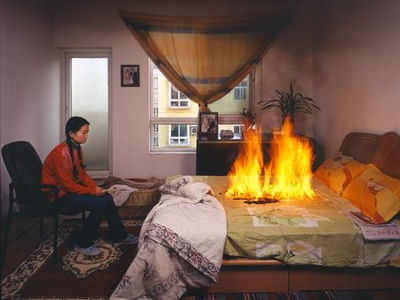

In [6]:
fire_images = list(data_dir.glob('fire/*'))
PIL.Image.open(str(fire_images[0]))

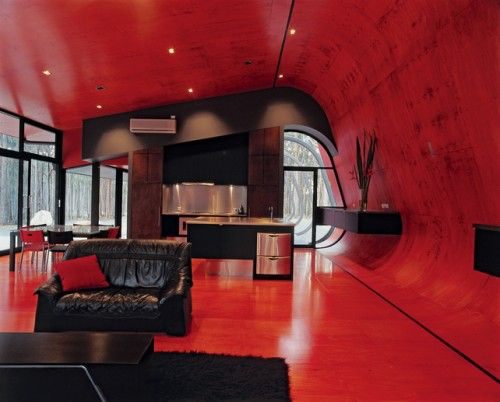

In [7]:
non_fire_images = list(data_dir.glob('non_fire/*'))
PIL.Image.open(str(non_fire_images[0]))

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1666 files belonging to 3 classes.
Using 1333 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1666 files belonging to 3 classes.
Using 333 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['fire', 'non_fire', 'test']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(help(tf.lite.TFLiteConverter))

In [ ]:
model.save(model_save_path)

In [12]:
from tensorflow.keras.models import load_model
model = load_model(model_save_path)

In [58]:
# print(model_save_path)
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('../results/model/fire_detection') # path to the SavedModel directory
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open(model_save_path+'/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [121]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

def classify_image(interpreter, image, top_k=1):
    """Returns a sorted array of classification results."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = np.squeeze(interpreter.get_tensor(output_details['index']))

  # If the model is quantized (uint8 data), then dequantize the results
    if output_details['dtype'] == np.uint8:
        scale, zero_point = output_details['quantization']
        output = scale * (output - zero_point)

    ordered = np.argpartition(-output, top_k)
    return [(i, output[i]) for i in ordered[:top_k]]


In [151]:
# rm -rf ~/.keras/datasets/test_img

# test_img_url = "https://www.thenationalnews.com/image/policy:1.670944:1519035841/image/jpeg.jpg?f=16x9&w=1200&$p$f$w=dfa40e8"
# test_img_url = 'https://climate.esa.int/media/images/Fire-CCI-banner_1.2e16d0ba.fill-600x314-c100.format-jpeg.jpg'
# test_img_url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/small-kitchen-1572367025.png'
# test_img_url = 'https://diy.sndimg.com/content/dam/images/hgtv/video/0/02/021/0216/0216772.jpg.rend.hgtvcom.1280.720.jpeg'
# test_img_url = 'https://images.indianexpress.com/2021/03/Pune-fire-1.jpg'
# test_img_url = 'https://i.insider.com/56843d15dd0895dc648b47fd?width=1000&format=jpeg&auto=webp'
# test_img_url = 'https://charlestonfire.org/images/public-news/large/news-1501509679.jpg'
# test_img_url = 'https://cf.ltkcdn.net/safety/images/std/116578-232x317r1-Kitchenfireprevention.jpg'
# test_img_path = tf.keras.utils.get_file('test_img', origin=test_img_url, cache_dir='../data')

test_img_path = '../data/fire_dataset/test/office_fire3.jpeg'

# print(test_img_path)

In [152]:
img = keras.preprocessing.image.load_img(
    test_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# print(img_array)

predictions = model.predict(img_array)
print('predictions: ', predictions)
score = tf.nn.softmax(predictions[0])

print('score: ', score)
print('Class: ', np.argmax(score))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

predictions:  [[ 10.171755    2.7643747 -10.064489  -10.431701  -11.49566  ]]
score:  tf.Tensor([9.9939358e-01 6.0639030e-04 1.6264750e-09 1.1266005e-09 3.8877429e-10], shape=(5,), dtype=float32)
Class:  0
This image most likely belongs to fire with a 99.94 percent confidence.


In [153]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_save_path+'/model.tflite')
interpreter.allocate_tensors()

_, height, width, _ = interpreter.get_input_details()[0]['shape']

image = Image.open(test_img_path).convert('RGB').resize((width, height),
                                                         Image.ANTIALIAS)

In [158]:
classes_names = ['fire', 'non_fire']

set_input_tensor(interpreter, image)

interpreter.invoke()

output = np.squeeze(interpreter.get_tensor(interpreter.get_output_details()[0]['index']))

if output_details['dtype'] == np.uint8:
    scale, zero_point = output_details['quantization']
    output = scale * (output - zero_point)

score = (np.exp(output).T / np.exp(output).sum(axis=-1)).T
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
    

This image most likely belongs to fire with a 99.93 percent confidence.
